In [1]:
# load relevant packages for analysis
import contextily as ctx
import dask.dataframe as dd
import dask_geopandas as dg
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import pyogrio
import seaborn as sns
from xml import etree
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
from shapely.geometry import LineString, MultiLineString
import shapely.wkt
import statsmodels.api as sm

# Simplify our Street Network Data
The OS OpenRoads .graph includes approx 3 million nodes & 3 million edges. In future stages of the project conducting analysis on this dataset will be computationally intensive.

There are two common methods used to simplify the size of the graph.

#### This code will
1. remove nodes of degree two and
2. replace roundabouts (nodes of degree higher than two, which are part of a cycle) with a single intersection point.

In [2]:
# read in uk street network data
G = nx.read_graphml("Data/road_network.graphml")

In [10]:
# create duplicate
G_percolation = G.copy()

### Check data

In [4]:
# print sample of nodes & edges
sample_nodes = list(G_percolation.nodes(data=True))[0]
print("\nSample nodes:")
for node in sample_nodes:
    print(node)
    
sample_edges = list(G_percolation.edges(data=True))[0]
print("\nSample edges:")
for edge in sample_edges:
    print(edge)


Sample nodes:
CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D
{'pos': '(187422.39, 887423.74)', 'form_of_road_node': 'junction', 'geometry': 'POINT (187422.39 887423.74)'}

Sample edges:
CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D
D3B5B123-54B7-467E-8C60-BE2383A3624B
{'length': 179.0, 'road_classification': 'Unknown', 'road_function': 'Restricted Local Access Road', 'form_of_way': 'Single Carriageway', 'primary_route': False, 'trunk_road': False, 'geometry': 'LINESTRING (187422.39 887423.74, 187436.12 887429.24, 187434.34 887455.56, 187439.76 887465.66, 187472.56 887482.08, 187552.42 887522.05)'}


### Simplify dataset and ensure all 

In [11]:
# Identify cycles in the graph
cycles = list(nx.cycle_basis(G_percolation))

# Function to merge edge attributes
def merge_edge_attributes(attr1, attr2):
    merged_attr = attr1.copy()
    for key, value in attr2.items():
        if key in merged_attr:
            if isinstance(merged_attr[key], (int, float)):
                merged_attr[key] += value
            else:
                merged_attr[key] = value
        else:
            merged_attr[key] = value
    return merged_attr

for cycle in cycles:
    if len(cycle) > 2:
        intersection_node = cycle[0]
        if not G_percolation.has_node(intersection_node):
            continue  # If the intersection node is already removed, skip this cycle

        new_edges = []
        for node in cycle[1:]:
            if not G_percolation.has_node(node):
                continue  # If the node is already removed, skip to the next node
            
            neighbors = list(G_percolation.neighbors(node))
            for neighbor in neighbors:
                if neighbor not in cycle and G_percolation.has_node(neighbor):
                    # Retain edge attributes
                    if G_percolation.has_edge(node, neighbor):
                        edge_attrs = G_percolation[node][neighbor]
                        if not G_percolation.has_edge(intersection_node, neighbor):
                            new_edges.append((intersection_node, neighbor, edge_attrs))
                        else:
                            existing_edge_attrs = G_percolation[intersection_node][neighbor]
                            merged_attrs = merge_edge_attributes(existing_edge_attrs, edge_attrs)
                            new_edges.append((intersection_node, neighbor, merged_attrs))
            # Retain node attributes
            node_attrs = G_percolation.nodes[node]
            for key, value in node_attrs.items():
                if key not in G_percolation.nodes[intersection_node]:
                    G_percolation.nodes[intersection_node][key] = value
            G_percolation.remove_node(node)

        # Add new edges after nodes are processed to avoid duplicate additions
        for u, v, attrs in new_edges:
            G_percolation.add_edge(u, v, **attrs)


In [12]:
# check size of G
print(f"Number of nodes: {G_percolation.number_of_nodes()}")
print(f"Number of edges: {G_percolation.number_of_edges()}")

Number of nodes: 1685538
Number of edges: 1896546


In [8]:
# print sample of nodes & edges
sample_nodes = list(G_percolation.nodes(data=True))[0]
print("\nSample nodes:")
for node in sample_nodes:
    print(node)
    
sample_edges = list(G_percolation.edges(data=True))[0]
print("\nSample edges:")
for edge in sample_edges:
    print(edge)


Sample nodes:
CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D
{'pos': '(187422.39, 887423.74)', 'form_of_road_node': 'junction', 'geometry': 'POINT (187422.39 887423.74)'}

Sample edges:
CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D
D3B5B123-54B7-467E-8C60-BE2383A3624B
{'length': 179.0, 'road_classification': 'Unknown', 'road_function': 'Restricted Local Access Road', 'form_of_way': 'Single Carriageway', 'primary_route': False, 'trunk_road': False, 'geometry': 'LINESTRING (187422.39 887423.74, 187436.12 887429.24, 187434.34 887455.56, 187439.76 887465.66, 187472.56 887482.08, 187552.42 887522.05)'}


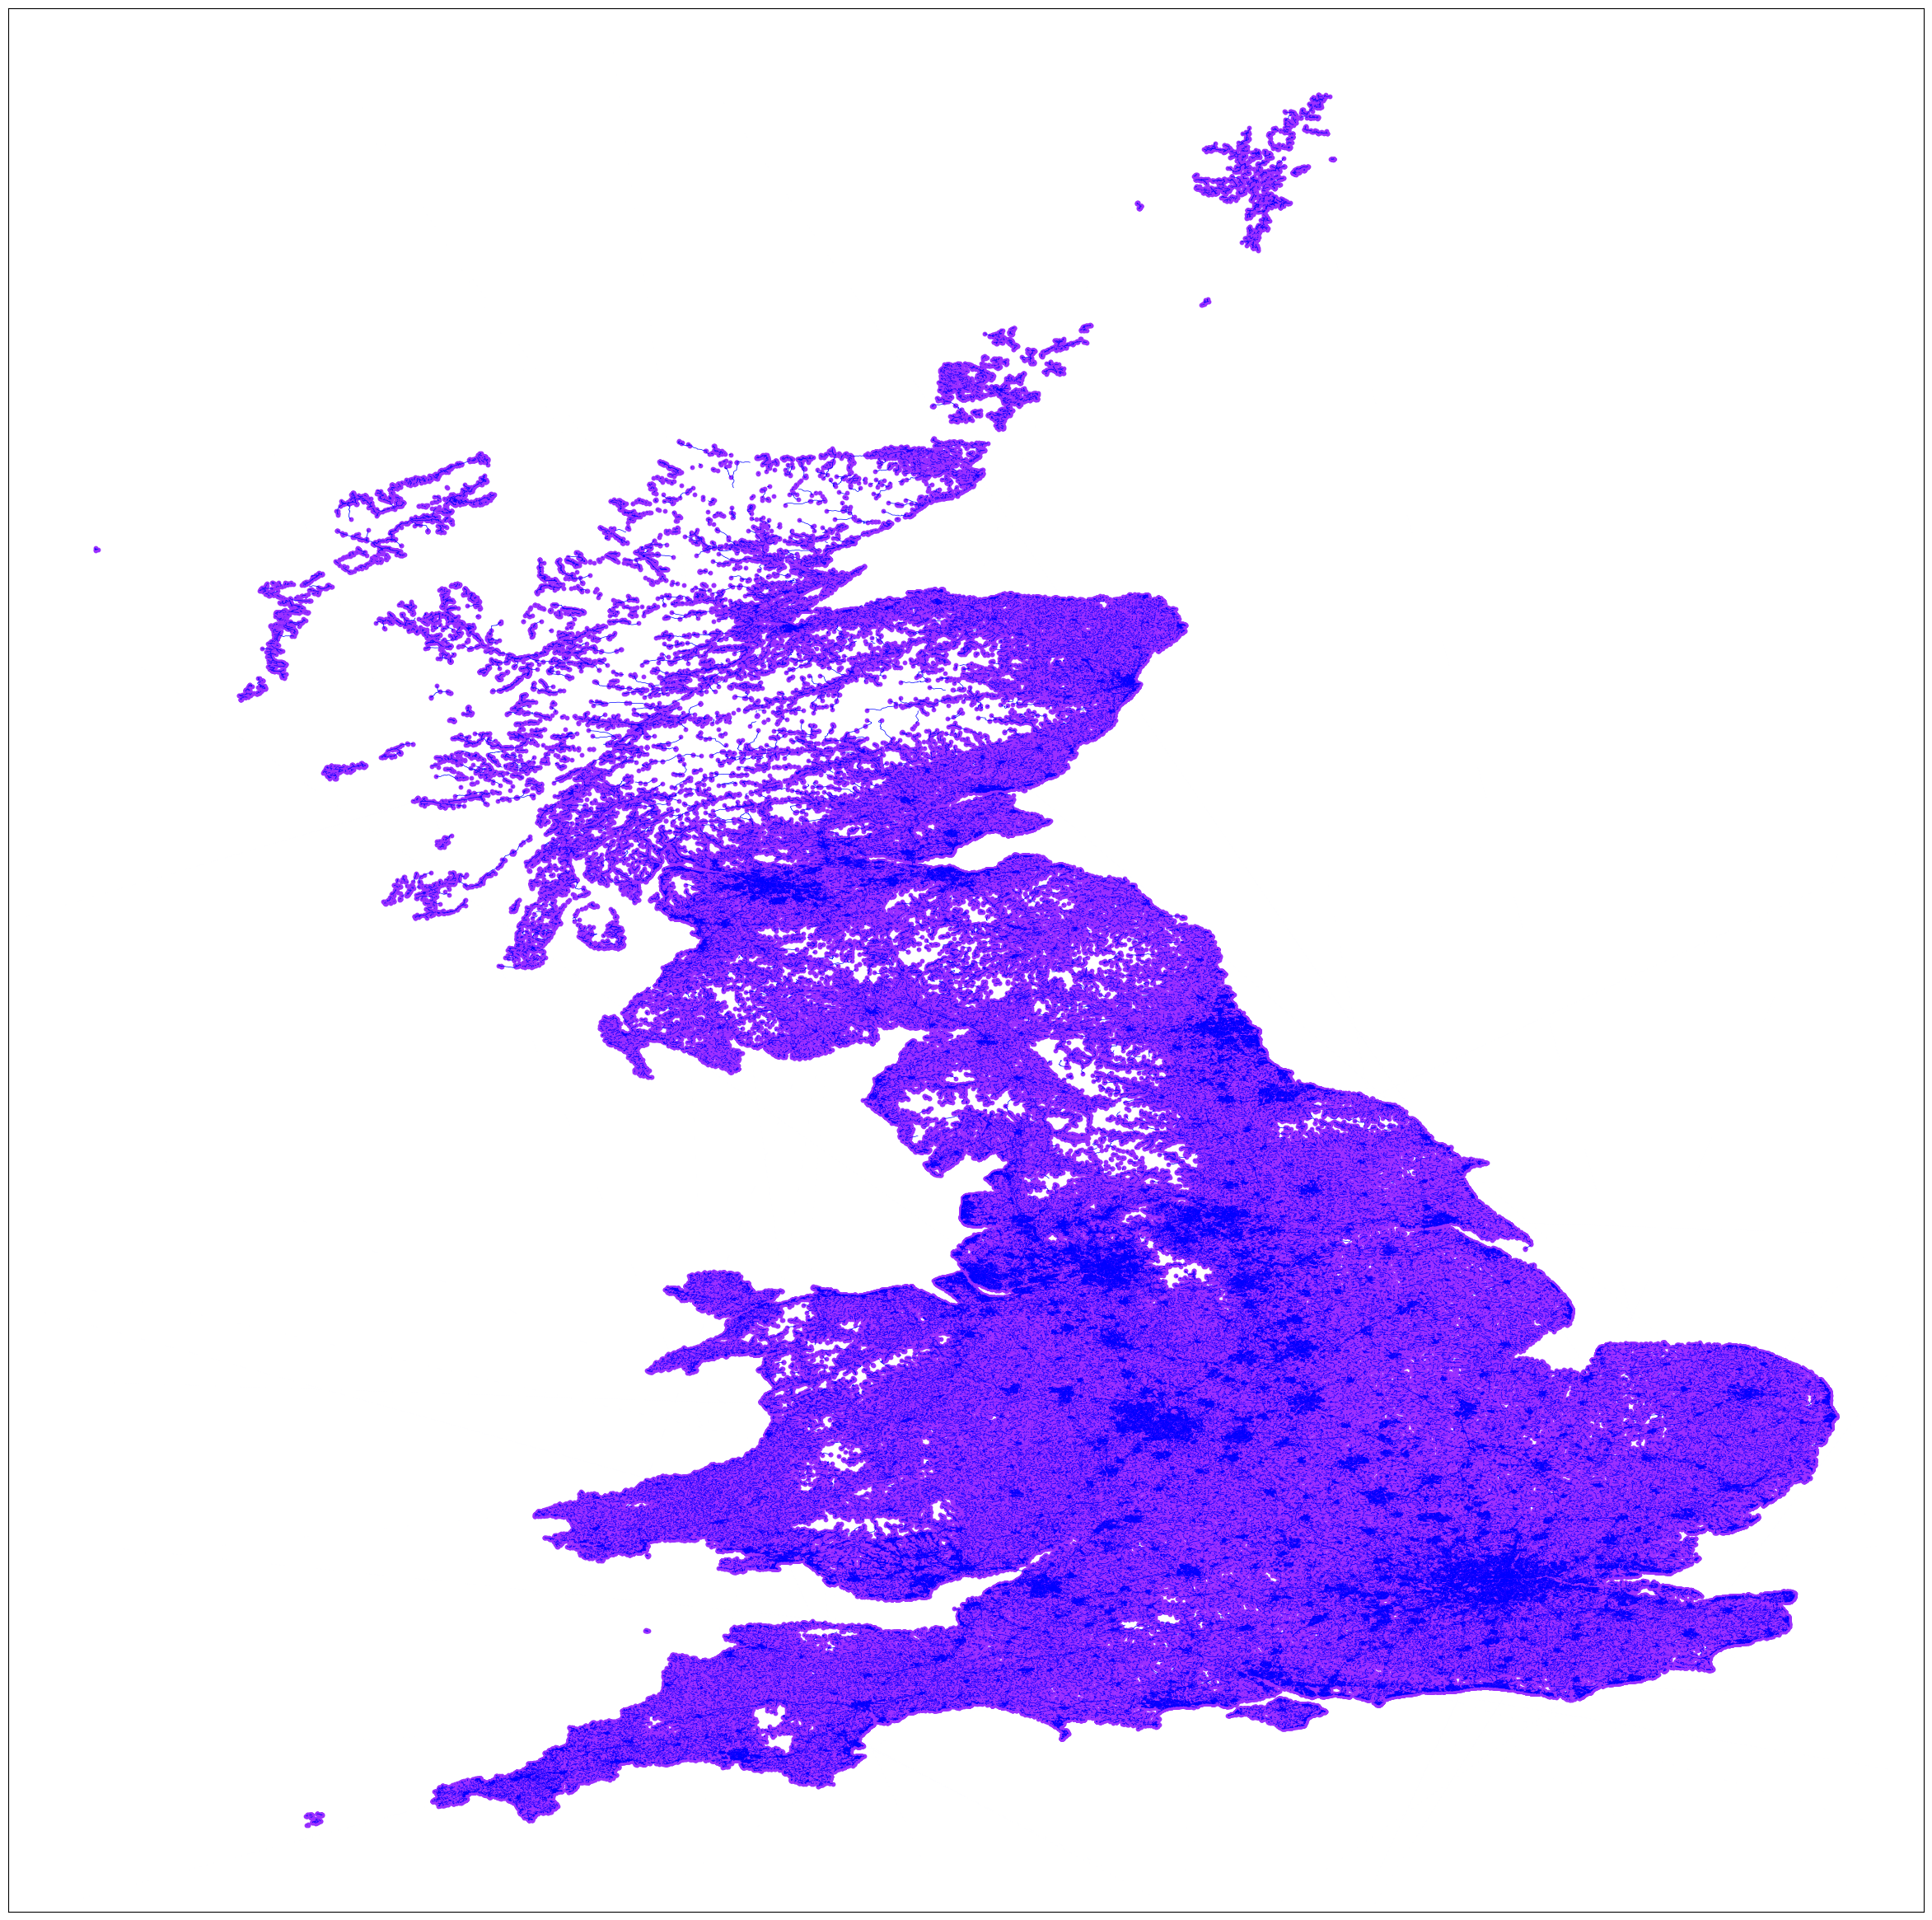

In [13]:
# define function to convert WKT format to tuples
def parse_linestring(geometry):
    if isinstance(geometry, str):
        line = shapely.wkt.loads(geometry)
        return list(line.coords)
    elif isinstance(geometry, LineString):
        return list(geometry.coords)
    else:
        raise ValueError(f"Unexpected geometry type: {type(geometry)}")

# get node positions from the 'pos' attribute
pos = {node: tuple(map(float, data['pos'].strip('()').split(','))) for node, data in G_percolation.nodes(data=True)}

# get edges & geometry converted to coordinate lists
lines = [parse_linestring(data['geometry']) for u, v, data in G_percolation.edges(data=True) if 'geometry' in data]

# LineCollection from the list of lines
lc = LineCollection(lines, colors='blue', linewidths=0.5)
fig, ax = plt.subplots(figsize=(30, 30))

# plot nodes
nx.draw_networkx_nodes(G_percolation, pos, node_size=10, node_color="#9B30FF", ax=ax)

# LineCollection to the plot
ax.add_collection(lc)

plt.show()

In [14]:
# save graph in GML format
nx.write_graphml(G_percolation, 'Data/G_simple.graphml')